In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Часть 1. Предобработка

In [46]:
data = pd.read_csv('./Algerian_forest_fires_dataset_UPDATE.csv')
data.head()

,,,,,,,,,,,,,Bejaia Region Dataset
day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire


In [47]:
tmp = data.iloc[0]

work_data = data.reset_index()
work_data.columns = ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes']
dataset1 = work_data.iloc[2:123]
dataset2 = work_data.iloc[125:-1]
dataset2 = dataset2.drop([125+43])

for key in ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']:
  dataset1[key] = pd.to_numeric(dataset1[key])
  dataset2[key] = pd.to_numeric(dataset2[key])
dataset1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
2,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
3,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
4,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
5,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
6,6,6,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


In [48]:
dataset1['Classes'].unique()

array(['not fire   ', 'fire   ', 'fire', 'fire ', 'not fire', 'not fire '],
      dtype=object)

Датасет кстати составлен одним местом! Надо будет исправить таргет лейблы

In [49]:
def transform_label(x):
  return x.strip()

dataset1['Classes'] = dataset1['Classes'].transform(transform_label)

dataset1['Classes'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array(['not fire', 'fire'], dtype=object)

Поскольку два датасета как-то много, зьмем из них только первый

Как будем работать с данными: для сохранения сезонности оставим месяц и год катгеорилаьными, а также введем колонку для абсолютного времени

In [50]:
date = pd.to_datetime(dataset1[['year', 'month', 'day']])
dataset1 = dataset1.join(pd.DataFrame({'date' : date} ) )
dataset1 = dataset1.drop('day', axis=1)

dataset1['date'] = dataset1['date'].astype('int');

dummy1 = pd.get_dummies(dataset1['year'], drop_first=True)
dataset1 = pd.concat([dataset1, dummy1], axis=1).drop('year', axis=1)

dummy2 = pd.get_dummies(dataset1['month'], drop_first=True)
dataset1 = pd.concat([dataset1, dummy2], axis=1).drop('month', axis=1)

dummy3 = pd.get_dummies(dataset1['Classes'], drop_first=True)
dataset1 = pd.concat([dataset1, dummy3], axis=1).drop('Classes', axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """


In [51]:
dataset1.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,date,7,8,9,not fire
2,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,1338595200000000000,0,0,0,1
3,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,1338681600000000000,0,0,0,1
4,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,1338768000000000000,0,0,0,1
5,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,1338854400000000000,0,0,0,1
6,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,1338940800000000000,0,0,0,0


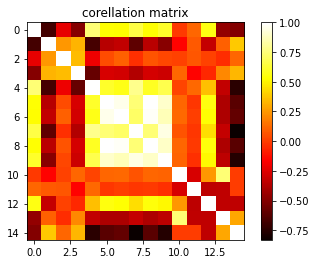

In [53]:
A = dataset1.corr().to_numpy()

plt.title('corellation matrix')
plt.imshow(A, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Часть 2. Гауссовские процесс для регрессии

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'Temperature';
cols = dataset1.columns

X_train, X_test, y_train, y_test = train_test_split(dataset1[cols[cols!=target]], dataset1[target], test_size=0.15)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test);

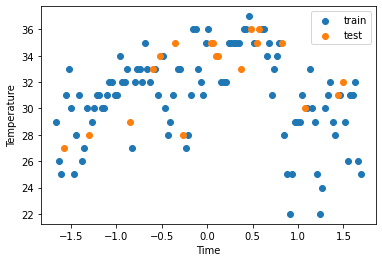

In [101]:
plt.scatter(X_train[:, 9], y_train, label='train')
plt.scatter(X_test[:, 9], y_test, label='test')
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.show()

Наблюдения:
1) Нет периодичности
2) Данные выглядят немного шумно

За ядро возьмем класс Matern kernels, что является обобщением RBF

In [117]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error

kernel = Matern()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)
print(gpr.score(X_test, y_test))

y_pred = gpr.predict(sc.transform(dataset1[cols[cols!=target]].to_numpy()))
print('MSE :', mean_squared_error(y_test, gpr.predict(X_test)))

0.42454313082269923
MSE : 4.676981867496401


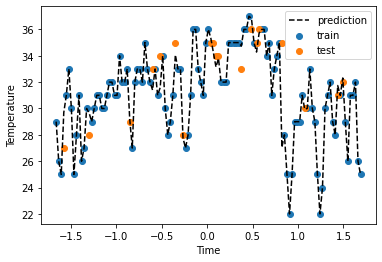

In [118]:
plt.scatter(X_train[:, 9], y_train, label='train')
plt.scatter(X_test[:, 9], y_test, label='test')

x = sc.transform(dataset1[cols[cols!=target]].to_numpy())[:, 9]
inds = np.argsort(x)
plt.plot(x[inds], y_pred[inds], label='prediction', linestyle='--', color='k')
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.show()

# Часть 2. Гауссовсие процессы для классификации

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'not fire';
cols = dataset1.columns

X_train, X_test, y_train, y_test = train_test_split(dataset1[cols[cols!=target]], dataset1[target], test_size=0.15)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test);

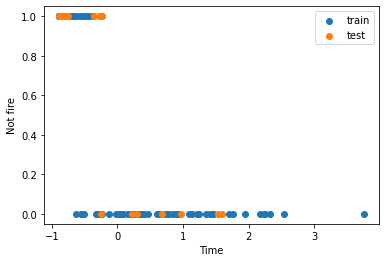

In [120]:
plt.scatter(X_train[:, 9], y_train, label='train')
plt.scatter(X_test[:, 9], y_test, label='test')
plt.legend()
plt.ylabel('Not fire')
plt.xlabel('Time')
plt.show()

In [125]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import f1_score

kernel = RBF()
gpr = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X_train, y_train)
y_pred = gpr.predict(X_test)
print('f1-score:', f1_score(y_test, y_pred))

f1-score: 0.8181818181818182
